In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from datetime import datetime
import geopandas as gp

In [23]:
from pyspark.ml import base
import pyspark.sql.functions as psf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [3]:
from pyspark import SparkContext
sc = SparkContext('local[*]','temp')

22/07/25 19:59:13 WARN Utils: Your hostname, benjamin-precision resolves to a loopback address: 127.0.0.2, but we couldn't find any external IP address!
22/07/25 19:59:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/07/25 19:59:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/25 19:59:13 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: 40:e0:5a:36:c9:81:7a:bc


In [4]:
from pyspark.sql import SQLContext
sqlContext=SQLContext(sc)

In [5]:
def read_in_range(start_year,start_month,end_year,end_month,path='/media/benjamin/Data/Chicago_Transit/TNP/'):
    dt=np.dtype([('id',np.ulonglong),('start year',np.short),('start month',np.byte),('start day',np.byte),('start hour',np.byte),('start minute',np.byte),('start julian',np.double),('end year',np.short),('end month',np.byte),('end day',np.byte),('end hour',np.byte),('end minute',np.byte),('trip seconds',np.uint32),('trip miles',np.single),('pickup census tract',np.ulonglong),('dropoff census tract',np.ulonglong),('pickup community area',np.byte),('dropoff community area',np.byte),('fare',np.single),('tip',np.single),('addcharge',np.single),('trip total',np.single),('st auth',np.byte),('pool',np.byte),('pickup lat',np.double),('pickup lon',np.double),('dropoff lat',np.double),('dropoff lon',np.double)])
    
    #Calculate month and year ranges
    nmonths=(end_year-start_year-1)*12.+(12.-start_month+1)+end_month
    yrs=(start_year+np.floor((start_month+np.arange(0,nmonths)-1)/12.)).astype(int)
    mos=(np.floor((np.mod(start_month+np.arange(nmonths)-1,12)+1 ))).astype(int)
    
    #construct list of file names
    fnames=''
    if nmonths > 1:
        for i in np.arange(0,nmonths,dtype=np.int16):
            fnames+=(path+"{0:04d}{1:02d}".format(yrs[i],mos[i])+'TNP.dat')
            if i != nmonths-1:
                fnames+=','
    else:
        fnames=path+"{0:04d}{1:02d}".format(yrs,mos)+'TNP.dat'
        
    #load binary records into rdd given record length
    rdd=sc.binaryRecords(fnames,104)
    out=rdd.map(read_array)
    df=out.toDF(['id','start year','start month','start day','start hour','start minute','start julian','end year','end month','end day','end hour','end minute','trip seconds','trip miles','pickup census tract','dropoff census tract','pickup community area','dropoff community area','fare','tip','addcharge','trip total','st auth','pool','pickup lat','pickup lon','dropaff lat','dropoff lon'])
    out.unpersist()
    return df

def area_out(df,ca,to_pandas=True):
    with_out=df.groupby(['start year','start month','start day','start hour','start julian','pickup community area']).count()
    out_area=with_out.where(with_out['pickup community area']==ca)
    out_area_sort=out_area.sort(['start year','start month','start day','start hour'])
    if to_pandas:
        outdf=out_area_sort.toPandas()
        outdf=outdf.rename(columns={'start year':'year','start month':'month','start day':'day','start hour':'hour'})
    else:
        outdf=out_area_sort.withColumnRenamed('start year','year').withColumnRenamed('start month','month').withColumnRenamed('start day','day').withColumnRenamed('start hour','hour')
    return outdf

In [6]:
rdd=sc.binaryRecords('/media/benjamin/Data/Chicago_Transit/TNP/2021*TNP.dat',104)

In [7]:
dt=np.dtype([('id',np.ulonglong),('start year',np.short),('start month',np.byte),('start day',np.byte),('start hour',np.byte),('start minute',np.byte),('start julian',np.double),('end year',np.short),('end month',np.byte),('end day',np.byte),('end hour',np.byte),('end minute',np.byte),('trip seconds',np.uint32),('trip miles',np.single),('pickup census tract',np.ulonglong),('dropoff census tract',np.ulonglong),('pickup community area',np.byte),('dropoff community area',np.byte),('fare',np.single),('tip',np.single),('addcharge',np.single),('trip total',np.single),('st auth',np.byte),('pool',np.byte),('pickup lat',np.double),('pickup lon',np.double),('dropoff lat',np.double),('dropoff lon',np.double)])

In [157]:
rdd.count()

42904003

In [8]:
def read_array(x):
    array=np.frombuffer(bytes(x),dtype=dt)
    #array=array.newbyteorder().byteswap() # big Endian
    return array.tolist()[0]

In [10]:
out=rdd.map(read_array)

In [11]:
zz=out.toDF(['id','start year','start month','start day','start hour','start minute','start julian','end year','end month','end day','end hour','end minute','trip seconds','trip miles','pickup census tract','dropoff census tract','pickup community area','dropoff community area','fare','tip','addcharge','trip total','st auth','pool','pickup lat','pickup lon','dropoff lat','dropoff lon'])

In [164]:
zz.show()

+---------+----------+-----------+---------+----------+------------+------------------+--------+---------+-------+--------+----------+------------+------------------+-------------------+--------------------+---------------------+----------------------+----+----+------------------+------------------+-------+----+-------------+--------------+-------------+--------------+
|       id|start year|start month|start day|start hour|start minute|      start julian|end year|end month|end day|end hour|end minute|trip seconds|        trip miles|pickup census tract|dropoff census tract|pickup community area|dropoff community area|fare| tip|         addcharge|        trip total|st auth|pool|   pickup lat|    pickup lon|  dropoff lat|   dropoff lon|
+---------+----------+-----------+---------+----------+------------+------------------+--------+---------+-------+--------+----------+------------+------------------+-------------------+--------------------+---------------------+----------------------+----

In [242]:
to_jday = F.udf(lambda row: pd.Timestamp(row[0],row[1],row[2],row[3]).to_julian_date())

In [250]:
to_dt = F.udf(lambda row: datetime(row[0],row[1],row[2],row[3]))

In [113]:
zz.withColumn('loop to ohare',(zz['dropoff community area']==74) & (zz['pickup community area']==32))

DataFrame[id: bigint, start year: bigint, start month: bigint, start day: bigint, start hour: bigint, start minute: bigint, end year: bigint, end month: bigint, end day: bigint, end hour: bigint, end minute: bigint, trip seconds: bigint, trip miles: double, pickup census tract: bigint, dropoff census tract: bigint, pickup community area: bigint, dropoff community area: bigint, fare: double, tip: double, addcharge: double, trip total: double, st auth: bigint, pool: bigint, pickup lat: double, pickup lon: double, dropoff lat: double, dropoff lon: double, loop to ohare: boolean]

In [246]:
repeater = F.udf(lambda x: x[0]*365.25*24+(x[1]-1)*30.5*24+(x[2]-1)*24+x[3])

In [251]:
zzt=zz.withColumn('repeated',to_dt(F.struct([zz[x] for x in zz.columns])))

In [252]:
zzt.show()

22/07/16 16:31:44 ERROR Executor: Exception in task 0.0 in stage 61.0 (TID 3812)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
   

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
    for item in iterator:
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_9512/3604848884.py", line 1, in <lambda>
ValueError: year 41462311 is out of range


In [209]:
bd=F.struct([zz[x] for x in zz.columns])

In [218]:
p=repeater(bd)

In [165]:
ab=zz.groupby(['start year','start month','start day','start hour','start julian','pickup community area']).count()

In [166]:
ab32=ab.where(ab['pickup community area']==32)

In [167]:
zb2=ab32.sort(['start year','start month','start day','start hour']).toPandas()

In [158]:
zb.tail(50)

,start year,start month,start day,start hour,pickup community area,count
3622,2020,10,29,22,32,279
3623,2020,10,29,23,32,185
3624,2020,10,30,0,32,98
3625,2020,10,30,1,32,53
3626,2020,10,30,2,32,33
3627,2020,10,30,3,32,21
3628,2020,10,30,4,32,28
3629,2020,10,30,5,32,80
3630,2020,10,30,6,32,146
3631,2020,10,30,7,32,202


In [168]:
zb2.tail(50)

,start year,start month,start day,start hour,start julian,pickup community area,count
8652,2021,12,29,22,2.459578e+06,32,244
8653,2021,12,29,23,2.459578e+06,32,142
8654,2021,12,30,0,2.459579e+06,32,73
8655,2021,12,30,1,2.459579e+06,32,46
8656,2021,12,30,2,2.459579e+06,32,25
8657,2021,12,30,3,2.459579e+06,32,21
8658,2021,12,30,4,2.459579e+06,32,29
8659,2021,12,30,5,2.459579e+06,32,54
8660,2021,12,30,6,2.459579e+06,32,73
8661,2021,12,30,7,2.459579e+06,32,85


In [178]:
fft=np.fft.fft(zb2['count']-np.mean(zb2['count']))

In [179]:
fft.size

8702

In [180]:
8702/24

362.5833333333333

In [181]:
8702/168

51.79761904761905

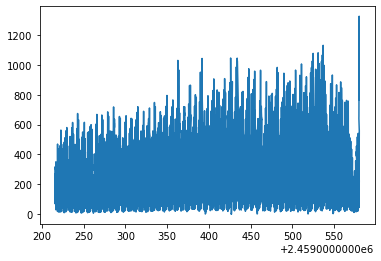

In [177]:
plt.plot(zb2['start julian'],zb2['count'])

(0.0, 1000.0)

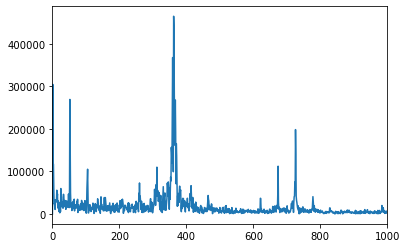

In [182]:
plt.plot(np.arange(0,8702),np.abs(fft))
plt.xlim([0,1000])

In [148]:
ts=pd.Timestamp(2008,12,11,16,4)

In [130]:
ts.to_julian_date()

2454812.1694444446

In [ ]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import IntegerType

df = sqlContext.createDataFrame([(None, None), (1, None), (None, 2)], ("a", "b"))

count_empty_columns = udf(lambda row: len([x for x in row if x == None]), IntegerType())

new_df = df.withColumn("null_count", count_empty_columns(struct([df[x] for x in df.columns])))

new_df.show()

In [ ]:
yrs=[2019,2020]

In [ ]:
yrmo=[(yr,mo)]

In [132]:
chicago=gp.read_file('/media/benjamin/Data/Chicago_Transit/Shapes/geo_export_43aec312-120e-4284-b1ca-b89761679d63.shp')

<AxesSubplot:>

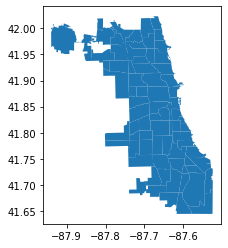

In [133]:
chicago.plot()

In [63]:
df=read_in_range(2021,8,2021,12)

In [64]:
cnt=area_out(df,32,to_pandas=False)

In [65]:
to_fit=cnt.withColumn('shortsine',F.sin(2*3.14159*F.col('start julian'))).withColumn('shortcos',F.cos(2*3.14159*F.col('start julian'))).withColumn('longsine',F.sin(2*3.14159*F.col('start julian')/7.)).withColumn('longcos',F.cos(2*3.14159*F.col('start julian')/7.)).withColumn('const',F.lit(1))

In [190]:
to_fit.show()

+----+-----+---+----+------------------+---------------------+-----+--------------------+--------------------+--------------------+-------------------+-----+
|year|month|day|hour|      start julian|pickup community area|count|           shortsine|            shortcos|            longsine|            longcos|const|
+----+-----+---+----+------------------+---------------------+-----+--------------------+--------------------+--------------------+-------------------+-----+
|2021|    8|  1|   0|2459428.0000000005|                   32|  888|-0.46731866488932017|  0.8840889465693276| -0.3703017898526959|-0.9289115051671445|    1|
|2021|    8|  1|   1|2459427.5416666674|                   32|  450| 0.22257373721968188| -0.9749158586770779|0.032059310757679614|-0.9994859681825166|    1|
|2021|    8|  1|   2| 2459427.583333334|                   32|  303|-0.03733684889848443| -0.9993027367691594|-0.00533505022336...|-0.9999857685182896|    1|
|2021|    8|  1|   3|2459427.6250000005|            

In [66]:
va=VectorAssembler(inputCols = ['const'],outputCol = 'features')

In [67]:
vto_fit = va.transform(to_fit)

In [68]:
r_fit = vto_fit.select(['features','count'])

In [69]:
r_fit.schema

StructType(List(StructField(features,VectorUDT,true),StructField(count,LongType,false)))

In [70]:
lr=LinearRegression(featuresCol = 'features',labelCol = 'count',maxIter=30,regParam=0.01)

In [71]:
lr_model=lr.fit(r_fit)

In [72]:
lr_model.coefficients

DenseVector([0.0])

In [48]:
trainingSummary=lr_model.summary

In [49]:
lr_model.getMaxBlockSizeInMB()

0.0

In [32]:
help(lr_model)

Help on LinearRegressionModel in module pyspark.ml.regression object:

class LinearRegressionModel(_JavaRegressionModel, _LinearRegressionParams, pyspark.ml.util.GeneralJavaMLWritable, pyspark.ml.util.JavaMLReadable, pyspark.ml.util.HasTrainingSummary)
 |  LinearRegressionModel(java_model=None)
 |  
 |  Model fitted by :class:`LinearRegression`.
 |  
 |  .. versionadded:: 1.4.0
 |  
 |  Method resolution order:
 |      LinearRegressionModel
 |      _JavaRegressionModel
 |      RegressionModel
 |      pyspark.ml.wrapper.JavaPredictionModel
 |      pyspark.ml.base.PredictionModel
 |      pyspark.ml.wrapper.JavaModel
 |      pyspark.ml.wrapper.JavaTransformer
 |      pyspark.ml.wrapper.JavaParams
 |      pyspark.ml.wrapper.JavaWrapper
 |      pyspark.ml.base.Model
 |      pyspark.ml.base.Transformer
 |      _LinearRegressionParams
 |      pyspark.ml.base._PredictorParams
 |      pyspark.ml.param.shared.HasLabelCol
 |      pyspark.ml.param.shared.HasFeaturesCol
 |      pyspark.ml.param.sha

In [ ]:
lr=LinearRegression()

In [18]:
pds=to_fit.select(['start julian','count']).toPandas()

22/07/25 20:01:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


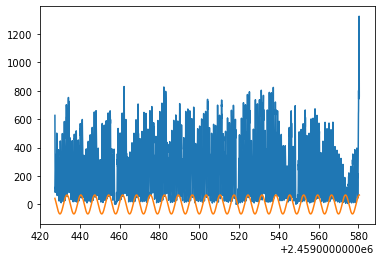

In [51]:
plt.plot(pds['start julian'],pds['count'])
plt.plot(pds['start julian'],53.8*np.sin(2.*3.14159*pds['start julian']/7.)-39.3*np.cos(2.*3.14159*pds['start julian']/7))
#plt.xlim([2459500,2459540])

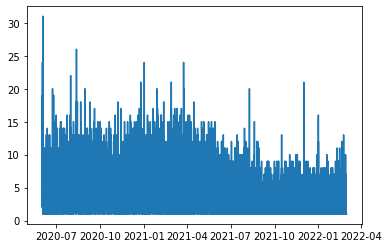

In [61]:
plt.plot(pd.to_datetime(cnt[['year','month','day','hour']]),cnt['count'])

In [58]:
fft=np.fft.fft(zb['count']-np.mean(zb['count']))

(0.0, 3000.0)

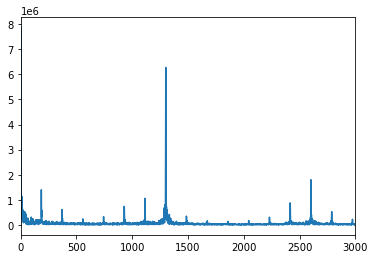

In [59]:
plt.plot(np.abs(fft))
plt.xlim([0,3000])

In [54]:
fft.size/(24*7)

185.82738095238096

In [64]:
zb.show()

AttributeError: 'DataFrame' object has no attribute 'show'

In [84]:
ab32.show()

+----------+-----------+---------+----------+---------------------+-----+
|start year|start month|start day|start hour|pickup community area|count|
+----------+-----------+---------+----------+---------------------+-----+
|      2021|          1|        1|         3|                   32|  219|
|      2021|          1|        5|        19|                   32|  254|
|      2021|          1|       19|        11|                   32|  203|
|      2021|          1|       16|        23|                   32|  244|
|      2021|          1|       27|        11|                   32|  227|
|      2021|          2|        5|         9|                   32|  296|
|      2021|          2|       17|        17|                   32|  377|
|      2021|          2|        2|         9|                   32|  254|
|      2021|          2|       15|        19|                   32|  135|
|      2021|          2|       15|         2|                   32|   29|
|      2021|          3|       18|    

In [ ]:
ab32['julday']=pd.to_datetime(zz[[]])

In [52]:
import TNPTools

In [ ]:
e